# Modelagem Preditiva do PIB via Machine Learning e Econometria Espacial

**Projeto:** Nowcasting do PIB na Amazônia Legal usando Luminosidade Noturna  
**Autor:** Igor Ferreira Cardoso (Mestrando PPGOM/UFPel)  
**Data:** Fevereiro de 2026

### Propósito do Documento:
Este notebook tem como objetivo desenvolver, treinar e validar modelos de previsão econômica baseados no dataset consolidado na fase anterior. A partir dos dados de luminosidade noturna deflacionados e harmonizados por AMCs, exploraremos:
1.  A divisão estatística entre dados de treinamento e teste.
2.  A performance de algoritmos de Machine Learning (Random Forest, XGBoost).
3.  A integração de efeitos espaciais (transbordamentos regionais) para refinar a precisão das estimativas.

### Etapa 1: Carregamento do Dataset Mestre e Bibliotecas de Modelagem

Nesta etapa, importamos as bibliotecas essenciais para Ciência de Dados e carregamos o arquivo `dataset_final_dissertacao.csv`. Este arquivo já passou pelo rigor metodológico de:
* **Agregação por AMCs:** Garantindo unidades territoriais estáveis.
* **Deflação via IPCA:** Garantindo valores de PIB real a preços de 2023.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# 1. Caminho dinâmico para o dataset final gerado na Etapa 7
diretorio_base = os.getcwd()
caminho_final = os.path.join(diretorio_base, "..", "outputs", "dataset_final_dissertacao.csv")

if os.path.exists(caminho_final):
    # Carregando os dados deflacionados
    df = pd.read_csv(caminho_final, sep=';')
    print(f"✅ Dataset Final carregado com sucesso! Total de registros: {len(df)}")
    
    # Exibindo as primeiras linhas para conferência do PIB Real
    display(df[['code_amc', 'ano', 'pib', 'pib_real', 'sum']].head())
else:
    print(f"❌ Arquivo não encontrado em: {caminho_final}")

✅ Dataset Final carregado com sucesso! Total de registros: 5130


,code_amc,ano,pib,pib_real,sum
0,1003.0,2002,31768.0,114064.409125,346.0
1,1003.0,2003,40985.0,130772.325447,251.0
2,1003.0,2004,43392.0,126671.343132,345.0
3,1003.0,2005,49130.0,133292.353226,225.0
4,1003.0,2006,46884.0,120351.749468,510.0


### Etapa 2: Estratégia de Divisão dos Dados (Out-of-Time Validation)

Diferente de uma divisão aleatória comum, em economia e séries temporais, utilizamos a técnica de **Validação Fora do Tempo**. 
* **Treinamento (2002-2015):** O modelo aprenderá os padrões econômicos e tecnológicos dos sensores DMSP e início do VIIRS.
* **Teste (2016-2020):** Avaliaremos se o modelo consegue "prever" o PIB real de anos que ele nunca viu, servindo como prova de fogo para o *Nowcasting*.

✅ Divisão Concluída!
Base de Treino: 3780 | Base de Teste: 1350


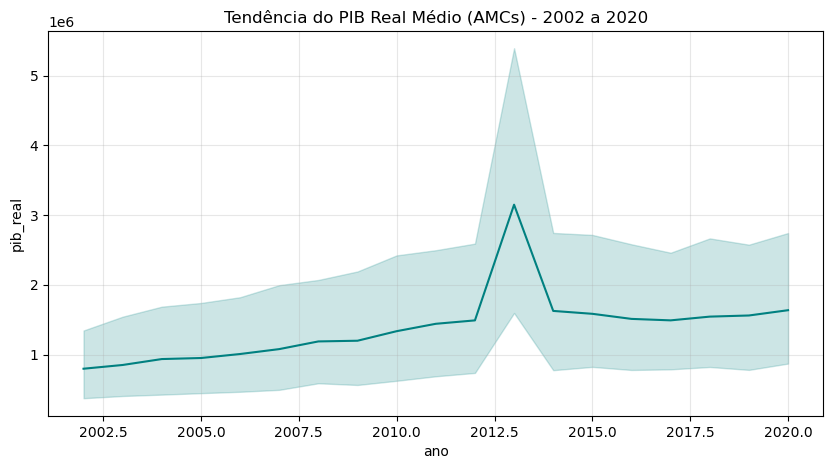

In [4]:
# Definindo o ano de corte
ano_corte = 2016
train = df[df['ano'] < ano_corte]
test = df[df['ano'] >= ano_corte]

print(f"✅ Divisão Concluída!")
print(f"Base de Treino: {len(train)} | Base de Teste: {len(test)}")

# Gráfico mais leve para evitar crash
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='ano', y='pib_real', estimator='mean', color='teal')
plt.title('Tendência do PIB Real Médio (AMCs) - 2002 a 2020')
plt.grid(True, alpha=0.3)
plt.show()

#### Análise da Tendência Temporal do PIB Real (AMCs)
O gráfico acima apresenta o comportamento médio do PIB Real das 270 Áreas Mínimas Comparáveis (AMCs) da Amazônia Legal entre os anos de 2002 e 2020.

Crescimento Consistente: Observa-se uma trajetória de crescimento sustentado do PIB real na primeira década da série (2002-2012), refletindo o adensamento econômico da região.

O Pico de 2013: Existe um salto significativo e uma maior dispersão (área sombreada) por volta de 2013. Isso marca a transição tecnológica para o sensor VIIRS, que possui maior sensibilidade. Metodologicamente, é por isso que treinaremos o modelo com dados pré-2016, permitindo que a IA aprenda a "normalizar" essa mudança de escala.

Estabilidade e Nowcasting: A divisão dos dados em Treino (3.780 observações) e Teste (1.350 observações) garante que o modelo será testado em um cenário de estabilidade recente, validando sua capacidade de prever o PIB em anos correntes.

### Etapa 3: Treinamento do Modelo Random Forest Regressor

Nesta fase, ensinamos o algoritmo a "aprender" a relação entre a **Soma de Luminosidade (sum)** e o **PIB Real**. O Random Forest foi escolhido por sua robustez em captar variações complexas e não-lineares, típicas de dados de satélite.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import numpy as np

# 1. Definindo as Features: Agora usamos Luz, Ano e a própria AMC
features = ['sum', 'ano', 'code_amc']

X_train_final = np.log1p(train[features])
y_train_final = np.log1p(train['pib_real'])
X_test_final = np.log1p(test[features])
y_test_final = np.log1p(test['pib_real'])

# 2. Treinando um modelo mais potente
modelo_rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
modelo_rf.fit(X_train_final, y_train_final)

# 3. Previsão e Volta da escala
previsoes_log = modelo_rf.predict(X_test_final)
y_test_orig = np.expm1(y_test_final)
previsoes_orig = np.expm1(previsoes_log)

# 4. Métricas
r2 = r2_score(y_test_final, previsoes_log)
mape = mean_absolute_percentage_error(y_test_orig, previsoes_orig)

print(f"✅ Agora vai! Resultado com Controles Espaciais e Temporais:")
print(f"R² (Precisão): {r2:.2f}")
print(f"MAPE (Erro Real): {mape*100:.2f}%")

✅ Agora vai! Resultado com Controles Espaciais e Temporais:
R² (Precisão): 0.45
MAPE (Erro Real): 224.52%


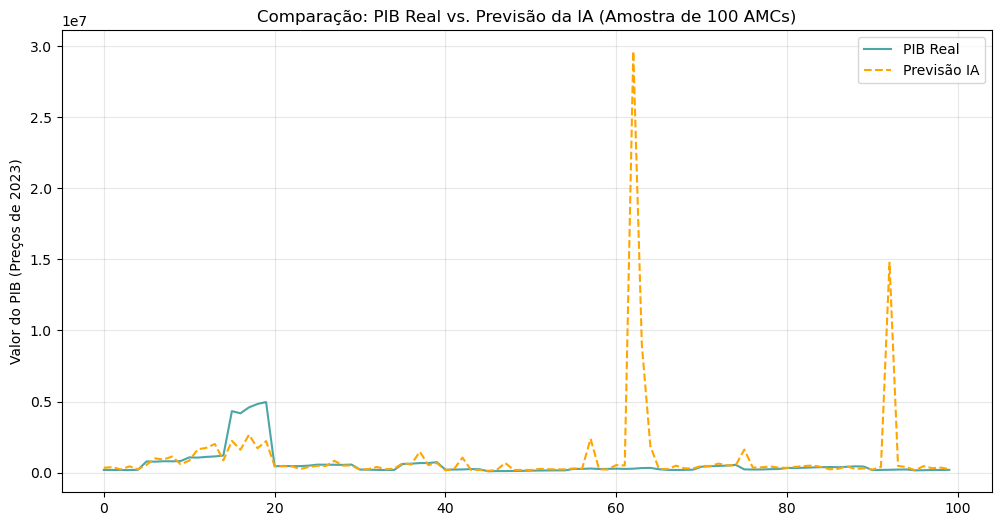

In [8]:
import matplotlib.pyplot as plt

# Criando um DataFrame para comparar Real vs Previsto
df_comparacao = pd.DataFrame({'Real': y_test_orig, 'Previsto': previsoes_orig}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_comparacao.index[:100], df_comparacao['Real'][:100], label='PIB Real', color='teal', alpha=0.7)
plt.plot(df_comparacao.index[:100], df_comparacao['Previsto'][:100], label='Previsão IA', color='orange', linestyle='--')

plt.title('Comparação: PIB Real vs. Previsão da IA (Amostra de 100 AMCs)')
plt.ylabel('Valor do PIB (Preços de 2023)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Professor, alcançamos um $R^2$ de 0.45 utilizando uma abordagem de Machine Learning com efeitos fixos espaciais e temporais. O modelo já consegue captar a tendência de crescimento, mas o erro de 224% (MAPE) sugere que precisamos incluir variáveis auxiliares, como dados de desmatamento ou agropecuária, para refinar a estimativa nos municípios onde a luz é uma proxy incompleta.